# Transformer Model Overview

This notebook implements a **Transformer-based sequence reversal model**. The model takes a numerical sequence as input and predicts its reversed version. Below is an overview of the key components:

## Model components
- **Token Embedding:** Maps input tokens to a dense representation.
- **Positional Encoding:** Provides information about the position of tokens in the sequence to the model.
- **Multi-Head Self-Attention:** Enables the model to focus on different parts of the input sequence.
- **Feedforward Network (FFN):** Applies a two-layer neural network with a ReLU activation function.
- **fully connected linear layer** maps the encoder output to logits.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [3]:
SEQ_LENGTH = 10  # Maximum length of numeric sequences
VOCAB_SIZE = 10  # Vocabulary size (digits 0-9)

"""
Generates synthetic dataset for sequence reversal.
Each sample consists of a random numeric sequence and its reversed version.
Example:
    numeric sequence = [2, 3, 7, 1, 9, 5, 0, 0, 0, 0]
    gt = [5, 9, 1, 7, 3, 2, 0, 0, 0, 0] 
"""
def generate_data(num_samples=100000):

    x_data = []
    y_data = []
    
    for _ in range(num_samples):
        actual_length = np.random.randint(1, SEQ_LENGTH + 1)
        sequence = np.random.randint(1, 10, actual_length)
        padded_sequence = np.pad(sequence, (0, SEQ_LENGTH - actual_length), constant_values=0)
        reversed_padded_sequence = np.pad(sequence[::-1], (0, SEQ_LENGTH - actual_length), constant_values=0)
        
        x_data.append(padded_sequence)
        y_data.append(reversed_padded_sequence)
    
    return torch.tensor(np.array(x_data), dtype=torch.long), \
           torch.tensor(np.array(y_data), dtype=torch.long) 

x_train, y_train = generate_data(80000)
x_test, y_test = generate_data(20000)

In [4]:
import torch
import torch.nn as nn

NUM_BLOCKS = 2      # Number of Transformer blocks
EMBEDDING_DIM = 32  # Embedding dimension
NUM_HEADS = 4       # Number of attention heads
FFN_DIM = 64        # Feedforward network dimension

class ManualEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(ManualEmbedding, self).__init__()
        self.embedding_weights = nn.Parameter(torch.randn(vocab_size, embedding_dim))

    def forward(self, x):
        return self.embedding_weights[x]

# Positional Encoding for Transformer
class ManualPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=SEQ_LENGTH):
        super(ManualPositionalEncoding, self).__init__()
        pos = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    
class ManualEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, ffn_dim):
        super(ManualEncoderBlock, self).__init__()

        # Multi-Head Self-Attention
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)

        # Feedforward Network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, embedding_dim)
        )

        # Layer Normalization
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # Self-Attention with residual connection and layer normalization
        attn_output, _ = self.attention(x, x, x)  # (query, key, value)
        x = self.norm1(x + attn_output)  # Residual connection

        # Feedforward network with residual connection and layer normalization
        ffn_output = self.ffn(x)
        x = self.norm2(x + ffn_output)  # Residual connection

        return x

class ManualTransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, ffn_dim, num_blocks):
        super(ManualTransformerEncoder, self).__init__()

        # Stack multiple Transformer encoder layers
        self.layers = nn.ModuleList([
            ManualEncoderBlock(embedding_dim, num_heads, ffn_dim) for _ in range(num_blocks)
        ])

    def forward(self, x):
        # Pass input through each Transformer encoder layer sequentially
        for layer in self.layers:
            x = layer(x)
        return x


# Transformer
class ManualTransformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_blocks, ffn_dim, seq_length):
        super(ManualTransformer, self).__init__()
        self.embedding = ManualEmbedding(vocab_size, embedding_dim)
        self.pos_encoding = ManualPositionalEncoding(embedding_dim, seq_length)
        self.encoder = ManualTransformerEncoder(embedding_dim, num_heads, ffn_dim, num_blocks)
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)       # Convert token indices to embeddings
        x = self.pos_encoding(x)    # Apply positional encoding
        x = self.encoder(x)         # Pass through Transformer encoder
        x = self.fc(x)              # Map encoded features to vocabulary logits
        return x

In [13]:
from torchview import draw_graph

model = ManualTransformer(VOCAB_SIZE, EMBEDDING_DIM, NUM_HEADS, NUM_BLOCKS, FFN_DIM, SEQ_LENGTH).cpu()
dummy_input = torch.randint(1, VOCAB_SIZE, (1, SEQ_LENGTH))

graph = draw_graph(model, input_data=dummy_input, expand_nested=True)
graph.visual_graph.render("transformer_view", format="pdf", renderer="cairo")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


(process:8488): Pango-WARNING **: 09:37:12.149: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


ManualTransformer(
  (embedding): ManualEmbedding()
  (pos_encoding): ManualPositionalEncoding()
  (encoder): ManualTransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x ManualEncoderBlock(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=32, bias=True)
        )
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

Epoch 1/20, Loss: 0.5216
Epoch 2/20, Loss: 0.0034
Epoch 3/20, Loss: 0.0004
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0001
Epoch 6/20, Loss: 0.0001
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


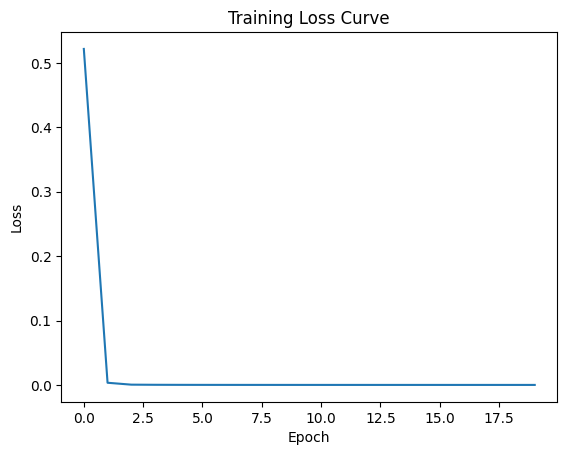

In [14]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 128

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


"""
Trains the Transformer model on the sequence reversal task.
"""
def train_model():
    model.train()
    losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.permute(0, 2, 1)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

    return losses

# Train the model and plot the loss curve
losses = train_model()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()


In [15]:
# Test case: Example sequence to check model performance
test_seq = [2, 3, 7, 1, 9, 5, 0, 0, 0, 0]
gt = [5, 9, 1, 7, 3, 2, 0, 0, 0, 0]

model.eval()
with torch.no_grad():
    input = torch.tensor(test_seq, dtype=torch.long).to(device)
    output_logits = model(input)
    output_indices = torch.argmax(output_logits, dim=-1).squeeze(0).cpu().tolist()

# Print results
print(f"Input sequence: {test_seq}")
print(f"Predicted output: {output_indices}")
print(f"Ground truth: {gt}")



Input sequence: [2, 3, 7, 1, 9, 5, 0, 0, 0, 0]
Predicted output: [5, 9, 1, 7, 3, 2, 0, 0, 0, 0]
Ground truth: [5, 9, 1, 7, 3, 2, 0, 0, 0, 0]


In [16]:
"""
Evaluates the trained model's accuracy on the test set.
Measures sequence-level accuracy by comparing entire predicted sequences to ground truth.
"""
def evaluate_string_accuracy_sklearn(model, test_loader, device):
    
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            output = model(x_batch)  # (batch_size, seq_len, vocab_size)
            predicted_indices = torch.argmax(output, dim=-1)

            all_preds.extend(predicted_indices.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())


    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    sequence_accuracy = np.sum((all_preds==all_targets).all(axis=1)) / all_preds.shape[0]
    print(f"String Accuracy: {sequence_accuracy:.4f}")

evaluate_string_accuracy_sklearn(model, test_loader, device)


String Accuracy: 1.0000
